In [1]:
import torch.nn.functional as Fun
import torch
from torch import nn
import torchvision.transforms as transforms
import numpy as np
import random
random_seed = 42  
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
)

In [2]:
class PizzaDataset(Dataset):
    def __init__(self, csv_file="train.csv", root="train_196", transform=None, target_transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        #print(self.root, self.labels.iloc[index, 1])
        img_path = os.path.join(self.root, self.labels.iloc[index, 1])
        img_path = os.path.join(self.root, img_path)
        image = Image.open(img_path)
        label = torch.tensor(int(self.labels.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
training_data = PizzaDataset(
    csv_file="train1.csv",
    root="train_196",
    transform=transforms.Compose([transforms.RandomChoice([transforms.RandomVerticalFlip(), 
                                                           transforms.RandomHorizontalFlip(), 
                                                           transforms.RandomRotation(45)]), 
                                  transforms.ToTensor()]),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

test_data = PizzaDataset(
    csv_file="labels.csv",
    root="test_196",
    transform=transforms.ToTensor(),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_

Original Images


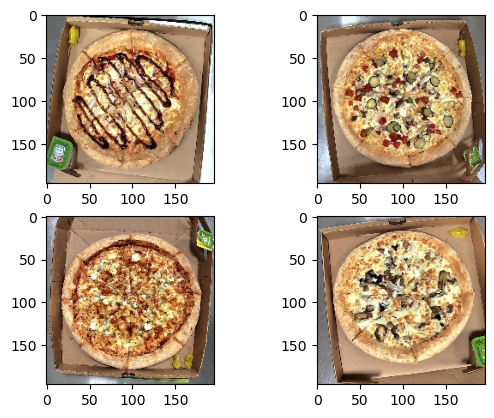

CutMix Images


In [ ]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[3] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return torch.Tensor(image_batch_updated),label


# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
for x, y in train_dataloader:
    image_batch = x
    image_batch_labels = y
    break
input_image = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch[:4], image_batch_labels[:4], 1.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch[2*i+j].numpy())
        plt.imshow(np.moveaxis(image_batch[2*i+j].numpy(),0,-1))
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)

['альфредо', 'баварская', 'вегетарианская', 'ветчинаибекон', 'ветчинаигрибы', 'гавайская', 'грушаbbq', 'капричиоза', 'клубникаизефир', 'крем-чизсгрибами', 'любимаядедамороза', 'любимаякарбонара', 'любимаяпапинапицца', 'маленькаяиталия', 'маргарита', 'мексиканская', 'миксгрин', 'мясная', 'мясноебарбекю', 'новогодняя', 'палочки', 'папамикс', 'пепперони', 'пепперонигрин', 'пицца8сыровnew', 'постная', 'рождественская', 'сананасомибеконом', 'сгрушейибеконом', 'сгрушейиголубымсыром', 'сердцепепперони-4сыра', 'сердцецыпленокбарбекю-пепперони', 'сливочнаяскреветками', 'суперпапа', 'сырная', 'томатнаяскреветками', 'улыбка', 'цыпленокбарбекю', 'цыпленокгрин', 'цыпленоккордонблю', 'цыпленокрэнч', 'цыпленокфлорентина', 'чеддермексикан', 'чеддерчизбургер', 'четыресыра', 'чизбургер']


C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


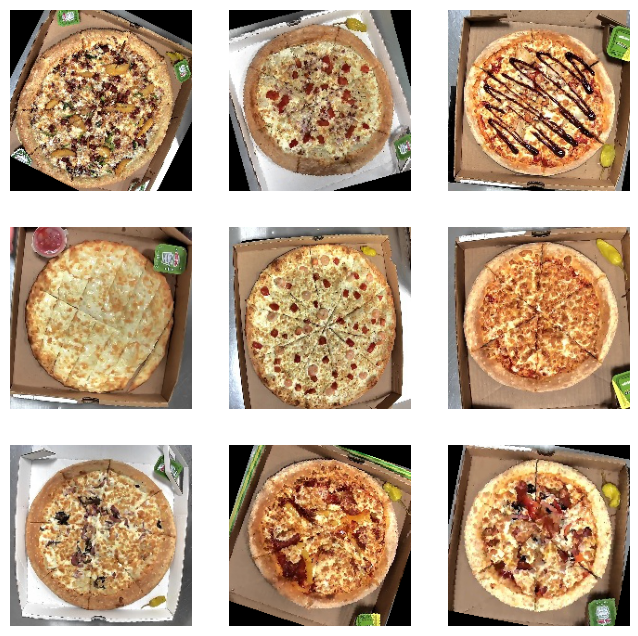

In [6]:
classes = """0: альфредо
1: баварская
2: вегетарианская
3: ветчинаибекон
4: ветчинаигрибы
5: гавайская
6: грушаbbq
7: капричиоза
8: клубникаизефир
9: крем-чизсгрибами
10: любимаядедамороза
11: любимаякарбонара
12: любимаяпапинапицца
13: маленькаяиталия
14: маргарита
15: мексиканская
16: миксгрин
17: мясная
18: мясноебарбекю
19: новогодняя
20: палочки
21: папамикс
22: пепперони
23: пепперонигрин
24: пицца8сыровnew
25: постная
26: рождественская
27: сананасомибеконом
28: сгрушейибеконом
29: сгрушейиголубымсыром
30: сердцепепперони-4сыра
31: сердцецыпленокбарбекю-пепперони
32: сливочнаяскреветками
33: суперпапа
34: сырная
35: томатнаяскреветками
36: улыбка
37: цыпленокбарбекю
38: цыпленокгрин
39: цыпленоккордонблю
40: цыпленокрэнч
41: цыпленокфлорентина
42: чеддермексикан
43: чеддерчизбургер
43: четыресыра
45: чизбургер"""

labels = classes.split()[1::2]
print(labels)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Случайный индекс из датасета
    img, label = training_data[sample_idx] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    #plt.title(labels[label])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(),0,-1))
plt.show()

In [7]:
img.numpy().shape

(3, 196, 196)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.cuda.empty_cache()

Using cuda device


In [9]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)#preprocess is also here
model.to(device)
model.train()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [10]:
loss_fn = nn.CrossEntropyLoss()

In [11]:
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [12]:
from tqdm import tqdm
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        X, y = generate_cutmix_image(X, y, 1.0)
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test_loop(dataloader, model, loss_fn, loss_list, acc_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    acc_list.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
def sent_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            preds.append(pred.cpu().numpy().argmax(1)[0])
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds

In [15]:
loss_list = []
acc_list = []

In [16]:
epochs = 17
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/de

Epoch 1
-------------------------------
loss: 7.627290  [    0/ 6379]
loss: 3.009869  [ 1280/ 6379]
loss: 1.346716  [ 2560/ 6379]
loss: 1.806516  [ 3840/ 6379]
loss: 0.982645  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  6%|████▉                                                                              | 1/17 [00:24<06:29, 24.36s/it]

Test Error: 
 Accuracy: 80.9%, Avg loss: 0.738497 

Epoch 2
-------------------------------
loss: 1.489104  [    0/ 6379]
loss: 1.769650  [ 1280/ 6379]
loss: 1.640787  [ 2560/ 6379]
loss: 0.999782  [ 3840/ 6379]
loss: 0.329492  [ 5120/ 6379]


 12%|█████████▊                                                                         | 2/17 [00:44<05:30, 22.03s/it]

Test Error: 
 Accuracy: 88.2%, Avg loss: 0.488815 

Epoch 3
-------------------------------
loss: 1.328266  [    0/ 6379]
loss: 1.216620  [ 1280/ 6379]
loss: 1.393676  [ 2560/ 6379]
loss: 0.495504  [ 3840/ 6379]
loss: 1.657702  [ 5120/ 6379]


 18%|██████████████▋                                                                    | 3/17 [01:05<04:57, 21.28s/it]

Test Error: 
 Accuracy: 88.6%, Avg loss: 0.463445 

Epoch 4
-------------------------------
loss: 1.093758  [    0/ 6379]
loss: 1.720125  [ 1280/ 6379]
loss: 1.137763  [ 2560/ 6379]
loss: 1.284441  [ 3840/ 6379]
loss: 1.197565  [ 5120/ 6379]


 24%|███████████████████▌                                                               | 4/17 [01:25<04:33, 21.04s/it]

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.296223 

Epoch 5
-------------------------------
loss: 0.188116  [    0/ 6379]
loss: 1.470356  [ 1280/ 6379]
loss: 0.934443  [ 2560/ 6379]
loss: 0.620523  [ 3840/ 6379]
loss: 1.152181  [ 5120/ 6379]


 29%|████████████████████████▍                                                          | 5/17 [01:46<04:09, 20.82s/it]

Test Error: 
 Accuracy: 94.2%, Avg loss: 0.356344 

Epoch 6
-------------------------------
loss: 1.166672  [    0/ 6379]
loss: 1.046308  [ 1280/ 6379]
loss: 0.311152  [ 2560/ 6379]
loss: 1.586313  [ 3840/ 6379]
loss: 1.351790  [ 5120/ 6379]


 35%|█████████████████████████████▎                                                     | 6/17 [02:06<03:47, 20.69s/it]

Test Error: 
 Accuracy: 95.2%, Avg loss: 0.273389 

Epoch 7
-------------------------------
loss: 1.978803  [    0/ 6379]
loss: 0.839361  [ 1280/ 6379]
loss: 1.154421  [ 2560/ 6379]
loss: 1.294814  [ 3840/ 6379]
loss: 0.681727  [ 5120/ 6379]


 41%|██████████████████████████████████▏                                                | 7/17 [02:27<03:25, 20.59s/it]

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.244806 

Epoch 8
-------------------------------
loss: 1.248465  [    0/ 6379]
loss: 0.972968  [ 1280/ 6379]
loss: 0.943671  [ 2560/ 6379]
loss: 1.183384  [ 3840/ 6379]
loss: 0.537693  [ 5120/ 6379]


 47%|███████████████████████████████████████                                            | 8/17 [02:47<03:04, 20.55s/it]

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.287158 

Epoch 9
-------------------------------
loss: 0.827677  [    0/ 6379]
loss: 0.872901  [ 1280/ 6379]
loss: 0.738886  [ 2560/ 6379]
loss: 1.021719  [ 3840/ 6379]
loss: 1.689574  [ 5120/ 6379]


 53%|███████████████████████████████████████████▉                                       | 9/17 [03:08<02:44, 20.54s/it]

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.218443 

Epoch 10
-------------------------------
loss: 0.927221  [    0/ 6379]
loss: 1.539740  [ 1280/ 6379]
loss: 0.898326  [ 2560/ 6379]
loss: 1.710268  [ 3840/ 6379]
loss: 1.195972  [ 5120/ 6379]


 59%|████████████████████████████████████████████████▏                                 | 10/17 [03:28<02:23, 20.53s/it]

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.244066 

Epoch 11
-------------------------------
loss: 1.056104  [    0/ 6379]
loss: 1.807890  [ 1280/ 6379]
loss: 0.528284  [ 2560/ 6379]
loss: 0.973295  [ 3840/ 6379]
loss: 0.936423  [ 5120/ 6379]


 65%|█████████████████████████████████████████████████████                             | 11/17 [03:48<02:02, 20.49s/it]

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.186701 

Epoch 12
-------------------------------
loss: 0.953001  [    0/ 6379]
loss: 0.790241  [ 1280/ 6379]
loss: 0.546818  [ 2560/ 6379]
loss: 1.009411  [ 3840/ 6379]
loss: 1.021666  [ 5120/ 6379]


 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [04:09<01:42, 20.48s/it]

Test Error: 
 Accuracy: 96.2%, Avg loss: 0.230151 

Epoch 13
-------------------------------
loss: 1.009210  [    0/ 6379]
loss: 0.966094  [ 1280/ 6379]
loss: 0.894274  [ 2560/ 6379]
loss: 0.965791  [ 3840/ 6379]
loss: 0.782509  [ 5120/ 6379]


 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [04:29<01:21, 20.46s/it]

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.236195 

Epoch 14
-------------------------------
loss: 0.900190  [    0/ 6379]
loss: 0.872977  [ 1280/ 6379]
loss: 1.989465  [ 2560/ 6379]
loss: 0.699481  [ 3840/ 6379]
loss: 0.848119  [ 5120/ 6379]


 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [04:50<01:01, 20.46s/it]

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.291482 

Epoch 15
-------------------------------
loss: 1.186898  [    0/ 6379]
loss: 0.948286  [ 1280/ 6379]
loss: 0.660277  [ 2560/ 6379]
loss: 0.715401  [ 3840/ 6379]
loss: 0.840344  [ 5120/ 6379]


 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [05:10<00:41, 20.52s/it]

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.189733 

Epoch 16
-------------------------------
loss: 0.570945  [    0/ 6379]
loss: 0.747998  [ 1280/ 6379]
loss: 1.260971  [ 2560/ 6379]
loss: 0.699049  [ 3840/ 6379]
loss: 2.068510  [ 5120/ 6379]


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [05:31<00:20, 20.48s/it]

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.215075 

Epoch 17
-------------------------------
loss: 0.896861  [    0/ 6379]
loss: 0.444560  [ 1280/ 6379]
loss: 0.873014  [ 2560/ 6379]
loss: 0.962324  [ 3840/ 6379]
loss: 0.853627  [ 5120/ 6379]


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [05:51<00:00, 20.69s/it]

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.187297 

Done!


In [17]:
learning_rate = 1e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_

loss: 0.578435  [    0/ 6379]
loss: 0.617107  [ 1280/ 6379]
loss: 0.825128  [ 2560/ 6379]
loss: 0.838243  [ 3840/ 6379]
loss: 0.699027  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:20<06:29, 20.50s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.170703 

Epoch 2
-------------------------------
loss: 0.968496  [    0/ 6379]
loss: 0.597079  [ 1280/ 6379]
loss: 0.724711  [ 2560/ 6379]
loss: 0.884987  [ 3840/ 6379]
loss: 0.644687  [ 5120/ 6379]


 10%|████████▎                                                                          | 2/20 [00:41<06:09, 20.52s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.173445 

Epoch 3
-------------------------------
loss: 0.561207  [    0/ 6379]
loss: 0.784065  [ 1280/ 6379]
loss: 0.670695  [ 2560/ 6379]
loss: 0.781077  [ 3840/ 6379]
loss: 0.799709  [ 5120/ 6379]


 15%|████████████▍                                                                      | 3/20 [01:01<05:47, 20.45s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.183354 

Epoch 4
-------------------------------
loss: 0.594028  [    0/ 6379]
loss: 0.756033  [ 1280/ 6379]
loss: 0.599205  [ 2560/ 6379]
loss: 0.959524  [ 3840/ 6379]
loss: 0.543017  [ 5120/ 6379]


 20%|████████████████▌                                                                  | 4/20 [01:22<05:29, 20.57s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.180714 

Epoch 5
-------------------------------
loss: 0.801349  [    0/ 6379]
loss: 0.674651  [ 1280/ 6379]
loss: 0.428243  [ 2560/ 6379]
loss: 0.744927  [ 3840/ 6379]
loss: 0.513054  [ 5120/ 6379]


 25%|████████████████████▊                                                              | 5/20 [01:42<05:08, 20.54s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.175920 

Epoch 6
-------------------------------
loss: 0.935667  [    0/ 6379]
loss: 0.498612  [ 1280/ 6379]
loss: 1.080195  [ 2560/ 6379]
loss: 0.789365  [ 3840/ 6379]
loss: 0.504519  [ 5120/ 6379]


 30%|████████████████████████▉                                                          | 6/20 [02:03<04:47, 20.51s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.168535 

Epoch 7
-------------------------------
loss: 0.696709  [    0/ 6379]
loss: 0.921287  [ 1280/ 6379]
loss: 0.872158  [ 2560/ 6379]
loss: 0.816057  [ 3840/ 6379]
loss: 0.896969  [ 5120/ 6379]


 35%|█████████████████████████████                                                      | 7/20 [02:23<04:26, 20.51s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.167558 

Epoch 8
-------------------------------
loss: 0.716633  [    0/ 6379]
loss: 0.592153  [ 1280/ 6379]
loss: 0.474887  [ 2560/ 6379]
loss: 0.678869  [ 3840/ 6379]
loss: 0.705175  [ 5120/ 6379]


 40%|█████████████████████████████████▏                                                 | 8/20 [02:44<04:06, 20.51s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.168877 

Epoch 9
-------------------------------
loss: 0.849737  [    0/ 6379]
loss: 0.549631  [ 1280/ 6379]
loss: 0.773603  [ 2560/ 6379]
loss: 0.850823  [ 3840/ 6379]
loss: 1.317744  [ 5120/ 6379]


 45%|█████████████████████████████████████▎                                             | 9/20 [03:04<03:45, 20.48s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.177399 

Epoch 10
-------------------------------
loss: 0.716341  [    0/ 6379]
loss: 0.797575  [ 1280/ 6379]
loss: 0.666362  [ 2560/ 6379]
loss: 1.149203  [ 3840/ 6379]
loss: 0.695490  [ 5120/ 6379]


 50%|█████████████████████████████████████████                                         | 10/20 [03:25<03:25, 20.57s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.167277 

Epoch 11
-------------------------------
loss: 0.780335  [    0/ 6379]
loss: 0.695001  [ 1280/ 6379]
loss: 0.853236  [ 2560/ 6379]
loss: 0.393399  [ 3840/ 6379]
loss: 0.738356  [ 5120/ 6379]


 55%|█████████████████████████████████████████████                                     | 11/20 [03:45<03:04, 20.53s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.173861 

Epoch 12
-------------------------------
loss: 0.576435  [    0/ 6379]
loss: 0.685042  [ 1280/ 6379]
loss: 0.814242  [ 2560/ 6379]
loss: 0.700717  [ 3840/ 6379]
loss: 0.731019  [ 5120/ 6379]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:06<02:44, 20.51s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.170379 

Epoch 13
-------------------------------
loss: 0.625954  [    0/ 6379]
loss: 0.835018  [ 1280/ 6379]
loss: 0.708870  [ 2560/ 6379]
loss: 0.634590  [ 3840/ 6379]
loss: 0.681122  [ 5120/ 6379]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:26<02:23, 20.50s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.175692 

Epoch 14
-------------------------------
loss: 0.674199  [    0/ 6379]
loss: 0.721105  [ 1280/ 6379]
loss: 0.734463  [ 2560/ 6379]
loss: 0.692422  [ 3840/ 6379]
loss: 0.619933  [ 5120/ 6379]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [04:47<02:03, 20.52s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.167560 

Epoch 15
-------------------------------
loss: 1.944702  [    0/ 6379]
loss: 0.741404  [ 1280/ 6379]
loss: 0.474888  [ 2560/ 6379]
loss: 0.827801  [ 3840/ 6379]
loss: 0.965919  [ 5120/ 6379]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:07<01:42, 20.45s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.174818 

Epoch 16
-------------------------------
loss: 0.822612  [    0/ 6379]
loss: 0.483060  [ 1280/ 6379]
loss: 0.542633  [ 2560/ 6379]
loss: 0.789017  [ 3840/ 6379]
loss: 0.718589  [ 5120/ 6379]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [05:27<01:21, 20.41s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.169784 

Epoch 17
-------------------------------
loss: 0.626817  [    0/ 6379]
loss: 1.031324  [ 1280/ 6379]
loss: 0.949037  [ 2560/ 6379]
loss: 0.781929  [ 3840/ 6379]
loss: 0.531770  [ 5120/ 6379]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [05:48<01:01, 20.40s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.168814 

Epoch 18
-------------------------------
loss: 0.809842  [    0/ 6379]
loss: 0.540420  [ 1280/ 6379]
loss: 0.598817  [ 2560/ 6379]
loss: 0.669757  [ 3840/ 6379]
loss: 0.759100  [ 5120/ 6379]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:08<00:40, 20.39s/it]

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.177040 

Epoch 19
-------------------------------
loss: 0.444942  [    0/ 6379]
loss: 0.692416  [ 1280/ 6379]
loss: 0.753662  [ 2560/ 6379]
loss: 0.873797  [ 3840/ 6379]
loss: 0.633881  [ 5120/ 6379]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [06:28<00:20, 20.38s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.170595 

Epoch 20
-------------------------------
loss: 0.939337  [    0/ 6379]
loss: 0.597270  [ 1280/ 6379]
loss: 0.228815  [ 2560/ 6379]
loss: 0.688491  [ 3840/ 6379]
loss: 0.731996  [ 5120/ 6379]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:49<00:00, 20.46s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.163521 

Done!


In [18]:
learning_rate = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 15
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_

loss: 0.527201  [    0/ 6379]
loss: 1.656653  [ 1280/ 6379]
loss: 0.735663  [ 2560/ 6379]
loss: 1.419405  [ 3840/ 6379]
loss: 0.620168  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  7%|█████▌                                                                             | 1/15 [00:20<04:44, 20.31s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.161697 

Epoch 2
-------------------------------
loss: 1.265258  [    0/ 6379]
loss: 1.067340  [ 1280/ 6379]
loss: 0.589726  [ 2560/ 6379]
loss: 1.018212  [ 3840/ 6379]
loss: 0.595641  [ 5120/ 6379]


 13%|███████████                                                                        | 2/15 [00:40<04:24, 20.32s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.167038 

Epoch 3
-------------------------------
loss: 1.376115  [    0/ 6379]
loss: 0.862391  [ 1280/ 6379]
loss: 0.728230  [ 2560/ 6379]
loss: 0.772274  [ 3840/ 6379]
loss: 0.126616  [ 5120/ 6379]


 20%|████████████████▌                                                                  | 3/15 [01:00<04:03, 20.30s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.164594 

Epoch 4
-------------------------------
loss: 0.596195  [    0/ 6379]
loss: 1.311401  [ 1280/ 6379]
loss: 0.631898  [ 2560/ 6379]
loss: 0.617694  [ 3840/ 6379]
loss: 0.813237  [ 5120/ 6379]


 27%|██████████████████████▏                                                            | 4/15 [01:21<03:43, 20.31s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.164408 

Epoch 5
-------------------------------
loss: 1.503358  [    0/ 6379]
loss: 0.529513  [ 1280/ 6379]
loss: 0.567214  [ 2560/ 6379]
loss: 0.591931  [ 3840/ 6379]
loss: 0.544025  [ 5120/ 6379]


 33%|███████████████████████████▋                                                       | 5/15 [01:41<03:23, 20.32s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.165271 

Epoch 6
-------------------------------
loss: 0.349312  [    0/ 6379]
loss: 0.586149  [ 1280/ 6379]
loss: 1.313167  [ 2560/ 6379]
loss: 1.033605  [ 3840/ 6379]
loss: 0.626123  [ 5120/ 6379]


 40%|█████████████████████████████████▏                                                 | 6/15 [02:02<03:03, 20.43s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.165193 

Epoch 7
-------------------------------
loss: 0.566499  [    0/ 6379]
loss: 0.710908  [ 1280/ 6379]
loss: 0.769648  [ 2560/ 6379]
loss: 0.752465  [ 3840/ 6379]
loss: 0.346359  [ 5120/ 6379]


 47%|██████████████████████████████████████▋                                            | 7/15 [02:22<02:43, 20.39s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.168607 

Epoch 8
-------------------------------
loss: 1.101952  [    0/ 6379]
loss: 0.463626  [ 1280/ 6379]
loss: 1.321676  [ 2560/ 6379]
loss: 0.849323  [ 3840/ 6379]
loss: 1.184154  [ 5120/ 6379]


 53%|████████████████████████████████████████████▎                                      | 8/15 [02:42<02:22, 20.37s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.172010 

Epoch 9
-------------------------------
loss: 0.722210  [    0/ 6379]
loss: 0.644821  [ 1280/ 6379]
loss: 0.548466  [ 2560/ 6379]
loss: 0.604817  [ 3840/ 6379]
loss: 0.773846  [ 5120/ 6379]


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [03:03<02:02, 20.36s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.167758 

Epoch 10
-------------------------------
loss: 1.375854  [    0/ 6379]
loss: 0.898943  [ 1280/ 6379]
loss: 0.729640  [ 2560/ 6379]
loss: 0.636398  [ 3840/ 6379]
loss: 0.786751  [ 5120/ 6379]


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [03:23<01:41, 20.37s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.166937 

Epoch 11
-------------------------------
loss: 0.645583  [    0/ 6379]
loss: 0.622249  [ 1280/ 6379]
loss: 0.501207  [ 2560/ 6379]
loss: 0.823916  [ 3840/ 6379]
loss: 0.341952  [ 5120/ 6379]


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [03:43<01:21, 20.35s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.167323 

Epoch 12
-------------------------------
loss: 0.599010  [    0/ 6379]
loss: 0.771865  [ 1280/ 6379]
loss: 0.163004  [ 2560/ 6379]
loss: 0.861815  [ 3840/ 6379]
loss: 0.579022  [ 5120/ 6379]


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [04:04<01:01, 20.33s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.165775 

Epoch 13
-------------------------------
loss: 1.256690  [    0/ 6379]
loss: 0.293092  [ 1280/ 6379]
loss: 0.705414  [ 2560/ 6379]
loss: 0.734922  [ 3840/ 6379]
loss: 0.776779  [ 5120/ 6379]


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [04:24<00:40, 20.34s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.166531 

Epoch 14
-------------------------------
loss: 0.695550  [    0/ 6379]
loss: 0.324001  [ 1280/ 6379]
loss: 0.709630  [ 2560/ 6379]
loss: 1.015083  [ 3840/ 6379]
loss: 0.749916  [ 5120/ 6379]


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [04:44<00:20, 20.33s/it]

Test Error: 
 Accuracy: 97.2%, Avg loss: 0.166661 

Epoch 15
-------------------------------
loss: 0.652850  [    0/ 6379]
loss: 0.937222  [ 1280/ 6379]
loss: 0.315202  [ 2560/ 6379]
loss: 0.801750  [ 3840/ 6379]
loss: 0.962818  [ 5120/ 6379]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [05:05<00:00, 20.34s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.165581 

Done!


In [19]:
checkpoint_filename = "my_modelfourthreg.pt"
torch.save(model.state_dict(), checkpoint_filename)

0.9747191011235955 51


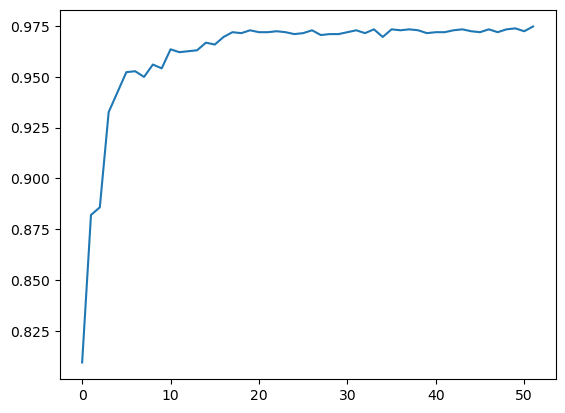

In [20]:
print(max(acc_list),np.argmax(np.array(acc_list)))
plt.plot(acc_list)

In [21]:
sent_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
model.train(False)
preds = sent_loop(sent_dataloader, model, loss_fn)

C:\Users\Артур\AppData\Local\Temp\ipykernel_14476\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


Test Error: 
 Accuracy: 97.5%, Avg loss: 0.167978 



In [23]:
print(len(preds))
d = {'id': np.arange(0,2136), 'label4': preds}
df=pd.DataFrame(data=d)
print(df)
df.to_csv('pred4.csv', index=False, header=True)

2136
        id  label4
0        0       0
1        1       0
2        2       0
3        3       0
4        4       0
...    ...     ...
2131  2131      45
2132  2132      45
2133  2133      45
2134  2134      45
2135  2135      45

[2136 rows x 2 columns]
